{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static'}


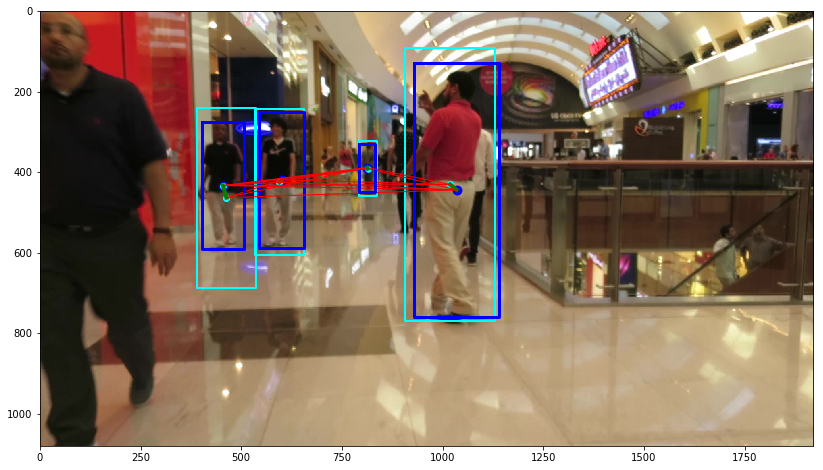

In [1]:
%matplotlib inline
import json
from pppr import aabb
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from pak.datasets.MOT import MOT16
from pak import utils
import matplotlib.pyplot as plt
import numpy as np
from pak.evaluation import MOTA

root = Settings['data_root']

from experiments import MOT16_Experiments

mot16 = MOT16_Experiments(root)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

# --- SELECT THE RIGHT VIDEO ----
X  = mot16.mot16_11_X
Dt = mot16.mot16_11_true_detections_no_pid

E = np.loadtxt('edges.txt')

def find_cost(i, j, E):
    for a, b, ce in E:
        if int(a) == int(i) and int(b) == int(j):
            return ce
    assert False

indx_frame1 = []
indx_frame2 = []
for idx, dt in enumerate(Dt):
    if dt[0] == 1:
        indx_frame1.append(idx)
    elif dt[0] == 2:
        indx_frame2.append(idx)

        
def get_center(aabb):
    _, x,y,w,h,_ = aabb
    return (x+w/2, y+h/2)
        
for j in indx_frame2:
    frame2, x, y, w, h, _ = Dt[j]
    assert frame2 == 2
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=2, c='cyan')
        

for i in indx_frame1:
    frame1, x, y, w, h, score = Dt[i]
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=3, c='blue')
    c_i = get_center(Dt[i])
    ax.scatter(c_i[0], c_i[1], color='blue', s=80)
    assert frame1 == 1
    for j in indx_frame2:
        c_j = get_center(Dt[j])
        ax.scatter(c_j[0], c_j[1], color='cyan', s=30)
        
        ce = find_cost(i, j, E)
        color = 'green' if ce > 0 else 'red'
        lw = 4 if ce > 0 else 1
        ax.plot([c_i[0], c_j[0]], [c_i[1], c_j[1]], color=color, lw=lw)


ax.imshow(X[1])
plt.show()

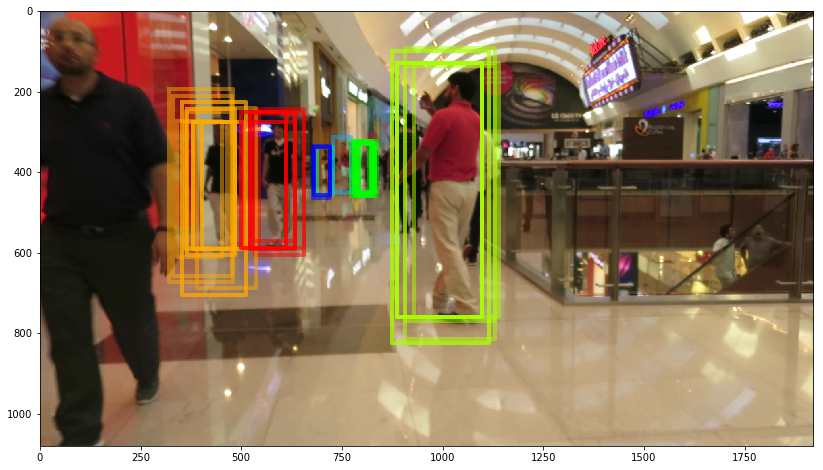

In [34]:
from numpy import genfromtxt
import numpy as np
from pak import utils
from cselect import color as cs

result = genfromtxt('build/result.txt', delimiter=' ', dtype='uint32')

def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes

Nodes = extract_ids(result)

# translate to sensible id's
n_unique = len(np.unique(Nodes))
lookup = {}
for new,old in zip(list(range(n_unique)), np.unique(Nodes)):
    lookup[old] = new

for i in range(len(Nodes)):
    Nodes[i] = lookup[Nodes[i]]



colors = cs.lincolor(n_unique+3) # handling of circlular red

n = len(Nodes)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

I = X[0]
ax.imshow(I)
for i in range(n):
    pid = Nodes[i]
    frame, x, y, w, h, score = Dt[i]
    c = colors[pid]/255
    assert frame < n
    
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=4, color=c, alpha=0.5)

    
plt.show()